## Imports

In [1]:
from class_definitions import Program, Merit, Target, Observation, Plan, Night
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.colors as mcolors
import astroplan
from astropy.time import Time, TimeDelta
from astropy.coordinates import SkyCoord, AltAz
import merits
import astropy.units as u
from tqdm.notebook import tqdm
import scheduler
from datetime import date, timedelta, datetime
import pickle
from helper_functions import load_program, build_observations

## Setup

In [2]:
# Define the programs
color_pallette = itertools.cycle([mcolors.rgb2hex(color) for color in plt.get_cmap("Set2").colors])

# Eventually this would be imported from the gitlab with the files.
prog600 = Program(600, "CORALIE", 0.034, next(color_pallette))
prog703 = Program(703, "CORALIE", 0.144, next(color_pallette))
prog708 = Program(708, "CORALIE", 0.062, next(color_pallette))
prog714 = Program(714, "CORALIE", 0.045, next(color_pallette))
prog500 = Program(500, "CORALIE", 0.205, next(color_pallette))
prog410 = Program(410, "ECAM", 0.161, next(color_pallette))

In [3]:
start_datetime = Time("2023-10-20 03:00:00")

In [4]:
# Time(datetime.combine(date(2023, 10, 20), datetime.min.time()))
start_datetime.datetime.date()
# Define global observer location
lasilla = astroplan.Observer.at_site("lasilla")

night = Night(start_datetime.datetime.date() - timedelta(days=1), 
              observations_within='nautical',
              observer = lasilla)

### Define the merits

In [5]:
# Define merits
cadence_merit = Merit("Cadence", merits.cadence, 
                      merit_type="efficiency", 
                      parameters={"delay": TimeDelta(4*u.day), "alpha":0.05})
airmass_merit = Merit("Airmass", merits.airmass, merit_type="veto", parameters={'max':1.8})
altitude_merit = Merit("Altitude", merits.altitude, merit_type="veto")
at_night_merit = Merit("AtNight", merits.at_night, merit_type="veto")
culmination_merit = Merit("Culmination", merits.culmination, merit_type="efficiency")
egress_merit = Merit("Egress", merits.egress, merit_type="efficiency")

In [6]:
# merits_list = [airmass_merit, altitude_merit, 
#                at_night_merit, culmination_merit, egress_merit]
merits_list = [airmass_merit, altitude_merit, 
               at_night_merit, culmination_merit]

### Load the targets

In [7]:
pct_keep = 0.75

Targets from 600

In [8]:
targets_600 = load_program("programs/Prog600COR_2023-10-19_obsinfo.csv", 
                           prog600, merits_list, pct_keep=pct_keep)
len(targets_600)

4

Targets from 708

In [9]:
targets_708 = load_program("programs/Prog708COR_2023-10-19_obsinfo.csv", 
                           prog708, merits_list, pct_keep=pct_keep)
len(targets_708)

15

Targets from 714

In [10]:
targets_714 = load_program("programs/Prog714COR_2023-10-19_obsinfo.csv", 
                           prog714, merits_list, pct_keep=pct_keep)
len(targets_714)

64

Targets from 500

In [11]:
cat500 = pd.read_csv("programs/Prog500COR_test.csv", skiprows=(1,))

In [12]:
targets_500 = []
for i, tar in cat500.iterrows():
    if tar['observable during the night']:
        # Use astroquery Simbad to get the coordinates
        skycoord = SkyCoord.from_name(tar['TIC'])
        merit_list = [airmass_merit, altitude_merit, at_night_merit, culmination_merit]
        phases = []
        if not np.isnan(tar['Phase1']):
            phases.append(tar['Phase1'])
        if not np.isnan(tar['Phase2']):
            phases.append(tar['Phase2'])
        phase_merit = Merit("Phase", merits.periodic_gaussian, merit_type="efficiency", 
                            parameters={'epoch': tar['Epoch'] + 2_400_000,
                                        'period': tar['Period'], 
                                        'sigma': 0.1,
                                        'phases': phases}
                                        )
        merit_list.append(phase_merit)
        target = Target(
            tar["TOI"],
            prog500,
            coords=skycoord,
            last_obs=(start_datetime-5*u.day).jd,
            priority=tar["Priority"],
        )
        target.add_merits(merit_list)
        targets_500.append(target)

In [13]:
print(targets_500[11])

Target(Name: TOI-2304,
       Program: 500,
       Coordinates: <SkyCoord (ICRS): (ra, dec) in deg
    (339.43601402, -30.60829519)>,
       Last observation: 2460232.625,
       Priority: 1.0,
       Fairness Merits: [],
       Veto Merits: [Merit(Airmass, veto, {'max': 1.8}), Merit(Altitude, veto, {}), Merit(AtNight, veto, {})],
       Efficiency Merits: [Merit(Culmination, efficiency, {}), Merit(Phase, efficiency, {'epoch': 2459063.80518, 'period': 9.4090393, 'sigma': 0.1, 'phases': [0.25, 0.75]})])


Targets from 410CAM

In [14]:
cat410_raw = pd.read_csv("programs/Prog410CAM_test.csv")
cat410_raw.head()

,Target,RA_deg,DEC_deg,priority,cadence,airmass
0,J0158-4325,29.6724,-43.417800,0,2,1.5
1,J0235-2433,38.8642,-24.553800,0,2,1.5
2,PSJ0259-2338,44.8899,-23.633800,0,2,1.5
3,HE0435-1223,69.5619,-12.287450,0,2,1.5
4,J0457-7820,74.2500,-78.333333,0,2,1.5


In [15]:
from astropy.coordinates import Angle
cat410 = (cat410_raw
          .assign(RA_hms = lambda df: Angle(df['RA_deg'], unit=u.deg).to_string(unit=u.hour, sep=':'))
          .assign(DEC_dms = lambda df: Angle(df['DEC_deg'], unit=u.deg).to_string(unit=u.degree, sep=':'))
          .assign(cadence = 3)
)
cat410['observable during the night'] = True
cat410.loc[8:14, 'observable during the night'] = False
cat410['coordinates (DACE)'] = cat410['RA_hms'] + ' / ' + cat410['DEC_dms']
cat410['last_obs'] = (start_datetime-5*u.day).jd
cat410['cadence percentage overdue [%]'] = (start_datetime.jd - (cat410['last_obs'] + cat410['cadence'])) * 100 / cat410['cadence']
cat410.drop(columns=['RA_deg', 'DEC_deg', 'RA_hms', 'DEC_dms'], inplace=True)
cat410.rename(columns={'Target':'catalog name'}, inplace=True)
cat410.head()

,catalog name,priority,cadence,airmass,observable during the night,coordinates (DACE),last_obs,cadence percentage overdue [%]
0,J0158-4325,0,3,1.5,True,1:58:41.376 / -43:25:04.08,2460232.625,66.666667
1,J0235-2433,0,3,1.5,True,2:35:27.408 / -24:33:13.68,2460232.625,66.666667
2,PSJ0259-2338,0,3,1.5,True,2:59:33.576 / -23:38:01.68,2460232.625,66.666667
3,HE0435-1223,0,3,1.5,True,4:38:14.856 / -12:17:14.82,2460232.625,66.666667
4,J0457-7820,0,3,1.5,True,4:57:00 / -78:20:00,2460232.625,66.666667


In [16]:
cat410.to_csv("programs/Prog410CAM_2023-10-19_obsinfo.csv", sep="\t", index=False)

In [17]:
targets_410 = load_program("programs/Prog410CAM_2023-10-19_obsinfo.csv", 
                           prog410, merits_list, pct_keep=1.0)
len(targets_410)

11

In [18]:
print(targets_410[2])

Target(Name: PSJ0259-2338,
       Program: 410,
       Coordinates: <SkyCoord (ICRS): (ra, dec) in deg
    (44.8899, -23.6338)>,
       Last observation: 4860232.625,
       Priority: 1.0,
       Fairness Merits: [],
       Veto Merits: [Merit(Airmass, veto, {'max': 1.8}), Merit(Altitude, veto, {}), Merit(AtNight, veto, {})],
       Efficiency Merits: [Merit(Culmination, efficiency, {})])


### Build the observations

In [19]:
# Merge the two programs
targets_all = targets_600 + targets_708 + targets_714 + targets_500 + targets_410

In [20]:
obs_600 = build_observations(targets_600, start_datetime, 
                             night, TimeDelta(20*u.min), "programs/obs_600.pkl")

In [21]:
obs_708 = build_observations(targets_708, start_datetime, 
                             night, TimeDelta(15*u.min), "programs/obs_708.pkl")

In [22]:
obs_714 = build_observations(targets_714, start_datetime, 
                             night, TimeDelta(15*u.min), "programs/obs_714.pkl")

In [23]:
obs_500 = build_observations(targets_500, start_datetime,
                                night, TimeDelta(40*u.min), "programs/obs_500.pkl")

In [24]:
obs_410 = build_observations(targets_410, start_datetime,
                             night, TimeDelta(33*u.min), "programs/obs_410.pkl")

In [25]:
test_observations = obs_600 + obs_708 + obs_714 + obs_500 + obs_410

## Test the merits

In [26]:
test_obs = test_observations[0]
print(test_obs)
print(test_obs.target)

Observation(Target: HD1581,
            Start time: 2460237.625,
            Exposure time: 0.013888888888888888,
            Score: 0.0)
Target(Name: HD1581,
       Program: 600,
       Coordinates: <SkyCoord (ICRS): (ra, dec) in deg
    (5.01791667, -64.87472222)>,
       Last observation: 2460178.84805948,
       Priority: 1.0,
       Fairness Merits: [],
       Veto Merits: [Merit(Airmass, veto, {'max': 1.8}), Merit(Altitude, veto, {}), Merit(AtNight, veto, {})],
       Efficiency Merits: [Merit(Culmination, efficiency, {})])


In [27]:
print(f"Cadence merit = {cadence_merit.evaluate(test_obs, verbose=True)}")

observation.start_time = 2460237.625
observation.target.last_obs = 2460178.84805948
delay.value = 4.0
Cadence merit = 2.840447404235384


In [28]:
print(f"Airmass merit = {airmass_merit.evaluate(test_obs)}")

Airmass merit = True


In [29]:
print(f"Altitude merit = {altitude_merit.evaluate(test_obs)}")

Altitude merit = True


In [30]:
print(f"Culmination merit = {culmination_merit.evaluate(test_obs, verbose=True)}")

Current altitude: 54.47529253685186
Max altitude: 54.51171089210749
Min altitude: 26.500720105594215
Altitude proportion: 0.9986998547986685
Culmination merit = 0.9986998547986685


In [31]:
print(f"Egress merit = {egress_merit.evaluate(test_observations[16], verbose=True)}")

Current time: 2460237.625
First time: 2460237.5760950577
Last time: 2460238.043685746
Observable range proportion: 0.10458921354991348
Egress merit = 0.10458921354991348


In [32]:
print(f"Phase merit = {phase_merit.evaluate(obs_500[5])}")

Phase merit = 0.9901382884907192


In [40]:
test_obs.feasible()
test_obs.evaluate_score(verbose=True)

Fairness: 1.0
Sensibility: 1.0
Efficiency: 0.9986998547986685
Rank score: 0.9986998547986685


0.9986998547986685

# Test the Schedulers

In [41]:
# Create the plan
plan_start = night.nautical_evening

## Simple greedy search

Greedy search is the equivalent of using `generateQ` with `K=1`

In [42]:
gQ_scheduler = scheduler.generateQ(plan_start)

# Create the plan
greedy_plan = gQ_scheduler.generateQ(test_observations, 
                                    max_plan_length = None, 
                                    K=1)

In [43]:
greedy_plan.print_stats()

Length = 26
Score = 0.996805
Evaluation = 0.917798
Overhead time = 0:38:05.190229
Overhead ratio = 0.07395
Observation time = 8:35:00
Observation ratio = 0.92074


In [44]:
print(greedy_plan)

Plan for the night of 2023-10-19 (Times in UTC)
--------------------------------------------------

 #      Program ID      Target                  Start time   (Exp time)
 1:	CORALIE	708	HD191391            	23:47:57     (0:15:00)
 2:	CORALIE	714	HD201933            	00:03:38     (0:15:00)
 3:	CORALIE	714	HD205123            	00:19:02     (0:15:00)
 4:	CORALIE	714	HD205478            	00:34:35     (0:15:00)
 5:	ECAM	410	DECALSJ2157-4201    	00:53:03     (0:33:00)
 6:	CORALIE	714	HD215104            	01:29:18     (0:15:00)
 7:	CORALIE	714	HD218266            	01:44:42     (0:15:00)
 8:	CORALIE	500	TOI-2304            	02:00:11     (0:40:00)
 9:	CORALIE	714	HD223549            	02:40:43     (0:15:00)
10:	CORALIE	714	HD770               	02:59:00     (0:15:00)
11:	CORALIE	600	HD1581              	03:14:32     (0:20:00)
12:	CORALIE	714	HD6793              	03:34:58     (0:15:00)
13:	CORALIE	714	HD5934              	03:50:36     (0:15:00)
14:	CORALIE	714	HD8651              	04:06:04     (

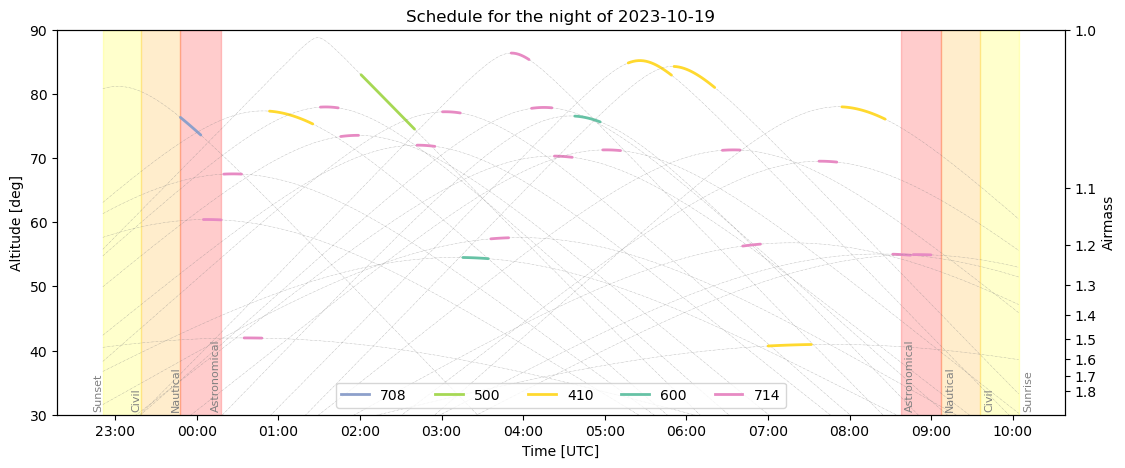

In [45]:
greedy_plan.plot(save=False)

In [43]:
# greedy_plan.plot_interactive()

## Greedy Look-Ahead with Top-K Selection: `generateQ`

This is similar to the simple greedy search but with a lookahead of the top K observations at each step. This approach explores different permutations of the top K observations and thus chooses the best one by looking forward.

In [43]:
# gQ_scheduler = scheduler.generateQ(plan_start)

# Create the plan
gQ_plan = gQ_scheduler.generateQ(test_observations, 
                                 max_plan_length = None, 
                                 K=5)

In [44]:
gQ_plan.print_stats()

Length = 29
Score = 0.996117
Evaluation = 0.899355
Overhead time = 0:44:43.456179
Overhead ratio = 0.08856
Observation time = 8:25:00
Observation ratio = 0.90286


In [45]:
print(gQ_plan)

Plan for the night of 2023-10-19 (Times in UTC)
--------------------------------------------------

 #      Program ID      Target          Start time   (Exp time)
 1:	CORALIE	708	BD-104886      	23:47:57     (0:15:00)
 2:	ECAM	410	PSJ2107-1611   	00:06:23     (0:20:00)
 3:	CORALIE	714	HD207895       	00:29:45     (0:15:00)
 4:	ECAM	410	DECALSJ2157-4201	00:47:58     (0:20:00)
 5:	CORALIE	714	HD209661       	01:11:09     (0:15:00)
 6:	CORALIE	714	HD218266       	01:26:37     (0:15:00)
 7:	CORALIE	714	HD215104       	01:42:01     (0:15:00)
 8:	CORALIE	500	TOI-2304       	01:57:26     (0:40:00)
 9:	CORALIE	714	HD223549       	02:37:58     (0:15:00)
10:	CORALIE	714	HD770          	02:56:16     (0:15:00)
11:	CORALIE	600	HD1581         	03:11:47     (0:20:00)
12:	CORALIE	714	HD6793         	03:32:13     (0:15:00)
13:	CORALIE	714	HD5934         	03:47:51     (0:15:00)
14:	CORALIE	714	HD8651         	04:03:20     (0:15:00)
15:	CORALIE	714	HD9362         	04:18:44     (0:15:00)
16:	CORALIE	714	

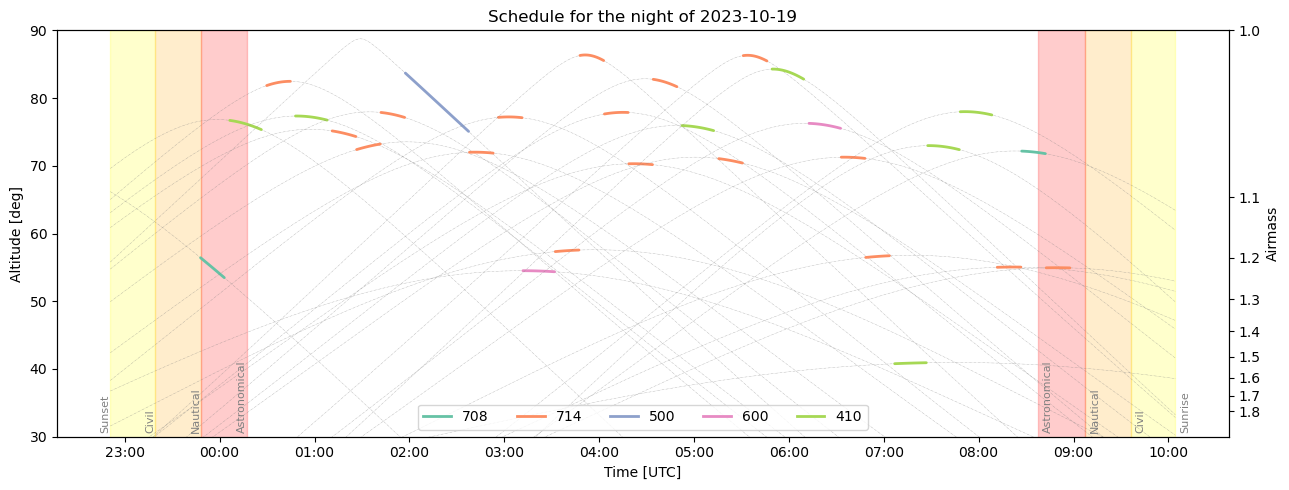

In [46]:
gQ_plan.plot(save=True)

## Recursive Dynamic Programming

In [77]:
# dpplanner = scheduler.DPPlanner()

# dpplan = dpplanner.dp_recursion(test_observations_noegress, 
#                                 Plan(), 
#                                 max_plan_length=10,
#                                 K = 4)

In [78]:
# print(f"Total recursion calls: {dpplanner.total_counter}")
# print(f"Saved recursion calls: {dpplanner.saved_state_counter}")

# print(dpplan[1])

In [79]:
# dpplan[1].plot()

## Beam Search

In [130]:
beamsearch = scheduler.BeamSearchPlanner(plan_start)

bs_plan = beamsearch.dp_beam_search(test_observations, 
                                    max_plan_length=None, 
                                    K=4)

In [131]:
bs_plan.print_stats()

Length = 27
Score = 0.783722
Evaluation = 0.742621
Overhead time = 0:28:24.093951
Overhead ratio = 0.05359
Observation time = 8:50:00
Observation ratio = 0.94756


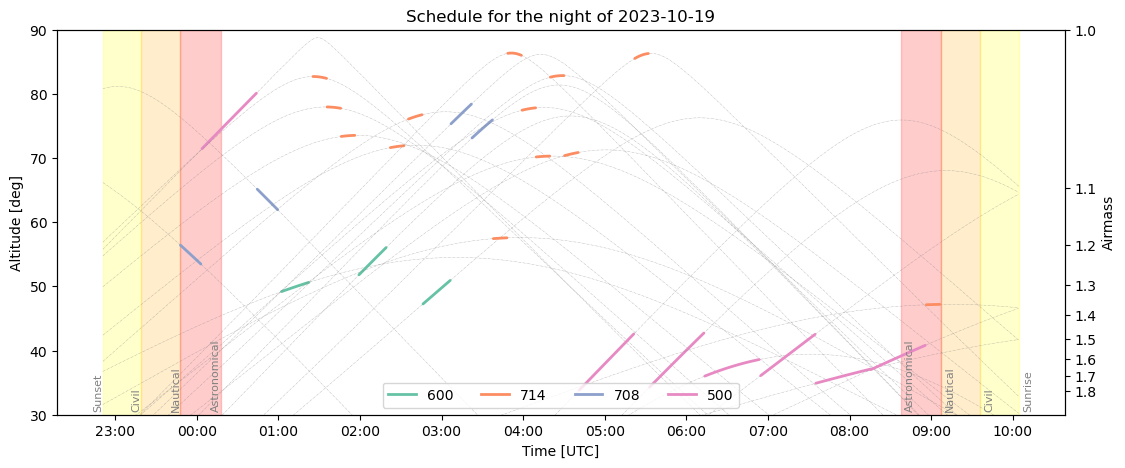

In [132]:
bs_plan.plot()

## Random tests